In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-phmw40b_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-phmw40b_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266458 sha256=1d447e86a308a275974799439b20b0843357105501ff91253558f893c32ea767
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpqeb0ol/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [2]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

class OpenDataset(torch.utils.data.Dataset):
# 데이터셋을 생성하고 Dataloader로 데이터셋을 불러오는 클래스
# transforms는 이미지 전처리(좌우 변환 등) 여부를 의미
    def __init__(self, root, df_path, transforms=None):
        self.root = root
        self.transforms = transforms
        self.df = df_path
        names = pd.read_csv(df_path)[['filename']]
        names = names.drop_duplicates()
        self.imgs = list(np.array(names['filename'].tolist()))

    def __getitem__(self, idx):
        # 이미지를 로드하고 roi 위치와 각 roi의 label 등 이미지의 정보 확인
        img_path = os.path.join(self.root, self.imgs[idx])
        if img_path.split('.')[-1] != 'png' : img_path += '.png'
        img = Image.open(img_path).convert("RGB")
        box_list, classes = parse_one_annot(self.df, self.imgs[idx])

        # 학습에 돌리기 적합한 형태(torch.Tensor 타입)로 변환
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        labels = torch.as_tensor(classes, dtype=torch.int64)
        image_id = torch.tensor([idx])
        # area는 roi에 해당하는 면적을 의미
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # roi가 다른 것으로부터 가려져있는지 여부
        # 전부 가려져 있지 않으므로 0
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_instance_segmentation_model(num_classes):
    # COCO에서 미리 학습된 인스턴스 분할 모델을 읽어옴
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # 미리 학습된 헤더를 새로운 것으로 교체
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # predictor를 새로운 것으로 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    return model

In [4]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # 학습시 50% 확률로 학습 영상을 좌우 반전 변환
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [6]:
def parse_one_annot(filepath, filename):
    # 이미지를 로드하고 roi 위치와 각 roi의 label을 확인
    # 이때, label값 0은 배경, 1은 코로나, 2는 결절, 3은 암에 해당
    data = pd.read_csv(filepath)
    boxes_array = data[data["filename"] == filename][["minX", "minY", "maxX", "maxY"]].values
    classnames = data[data["filename"] == filename][["classname"]]
    classes = []
    for i in range(len(classnames)) :
        if classnames.iloc[i, 0] =='covid-19' : classes.append(1)
        elif classnames.iloc[i, 0] =='nodule' : classes.append(2)
        elif classnames.iloc[i, 0] =='cancer' : classes.append(3)
    return boxes_array, classes

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# 경로 변경 필요
sample_root = '/content/drive/My Drive/test/sample/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# 데이터셋과 정의된 변환들 사용
dataset_train = OpenDataset(sample_root,sample_root+'annotations.csv', transforms = get_transform(train=True))
dataset_val = OpenDataset(sample_root,sample_root+'annotations.csv', transforms = get_transform(train=False))

# 데이터셋을 학습용과 검증용으로 나눔
# 현재는 전체 데이터셋 중 12개를 학습용으로, 3개를 검증용으로 사용
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-3])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-3:])

# 데이터 로더를 학습용과 검증용으로 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset_train), len(dataset_val)))


We have: 15 examples, 12 are training and 3 testing


In [11]:
num_classes = 3 # 샘플은 코로나, 결절로 구성되어 있으므로 3, 암을 추가하면 4가 되어야 함
# 학습을 GPU로 진행하되 GPU가 가용하지 않으면 CPU로 합니다
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# 모델을 GPU나 CPU로 옮김
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# 학습률 스케쥴러를 만듦
# learning rate scheduler decreases by 10x every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    # 1 에포크동안 학습하고, 10회 마다 출력
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 학습률을 업데이트
    lr_scheduler.step()
    # 검증 데이터셋에서 평가
    evaluate(model, data_loader_val, device=device)

# 만들어진 모델 저장
torch.save(model.state_dict(), "model.pth")

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [0/3]  eta: 0:00:12  lr: 0.002502  loss: 2.6849 (2.6849)  loss_classifier: 1.5591 (1.5591)  loss_box_reg: 0.0429 (0.0429)  loss_objectness: 1.0224 (1.0224)  loss_rpn_box_reg: 0.0605 (0.0605)  time: 4.2558  data: 2.5500  max mem: 3009
Epoch: [0]  [2/3]  eta: 0:00:01  lr: 0.005000  loss: 2.6849 (3.5085)  loss_classifier: 1.4895 (1.1945)  loss_box_reg: 0.0429 (0.0608)  loss_objectness: 1.0224 (1.9759)  loss_rpn_box_reg: 0.3484 (0.2773)  time: 1.9064  data: 0.8584  max mem: 3276
Epoch: [0] Total time: 0:00:05 (1.9590 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:00  model_time: 0.1340 (0.1340)  evaluator_time: 0.0018 (0.0018)  time: 0.3011  data: 0.1630  max mem: 3276
Test:  [2/3]  eta: 0:00:00  model_time: 0.1060 (0.1133)  evaluator_time: 0.0018 (0.0018)  time: 0.1735  data: 0.0569  max mem: 3276
Test: Total time: 0:00:00 (0.2007 s / it)
Averaged stats: model_time: 0.1060 (0.1133)  evaluator_time: 0.0018 (0.0018)
Accumulating evaluation results...
DONE (t=0.

In [24]:
# 만들어진 모델로 테스트 수행

# 현재는 검증 데이터의 사진 중 하나로 테스트를 수행함
# 이후 수정되어야 할 부분임
# 추가로, 학습량을 늘리게 된다면 아래 부분을 따로 파일로 만들어야 하며,
# load model을 추가해야 함
img, _ = dataset_val[0]
label_boxes = np.array(dataset_val[0][1]["boxes"])
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [25]:
# 예측 결과 출력
prediction

[{'boxes': tensor([[356.2901, 167.8123, 442.7684, 265.2445]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0541], device='cuda:0')}]

In [26]:
from PIL import ImageDraw

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(image)

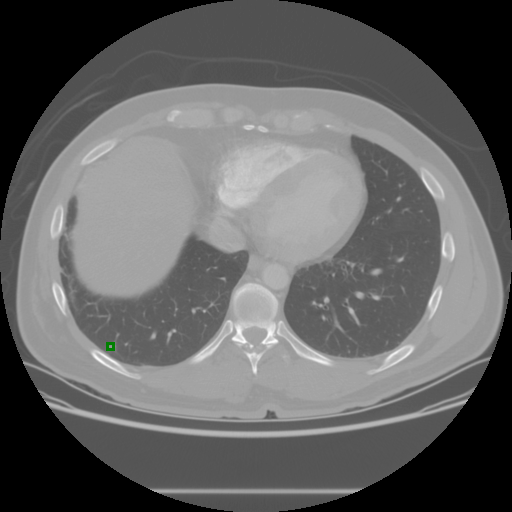

In [27]:
# 예측 결과를 화면에 출력
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image